In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.feature_selection import r_regression, f_regression
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy.stats import f
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy import stats

In [2]:
df = pd.read_csv('../data/CombinedSummaryByNeighborhoodQuarter2022.csv') 


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   uhf                168 non-null    float64
 1   neighborhood_name  168 non-null    object 
 2   year               172 non-null    int64  
 3   quarter            172 non-null    int64  
 4   er_visits          172 non-null    int64  
 5   air_quality        172 non-null    int64  
 6   asbestos           172 non-null    int64  
 7   covid              172 non-null    int64  
 8   electrical         172 non-null    int64  
 9   food               172 non-null    int64  
 10  garbage            172 non-null    int64  
 11  homelessness       172 non-null    int64  
 12  medical            172 non-null    int64  
 13  mold               172 non-null    int64  
 14  mosquitoes         172 non-null    int64  
 15  rodent             172 non-null    int64  
 16  safety             172 non

In [4]:
df.dropna(subset=['uhf','neighborhood_name'], inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 0 to 171
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   uhf                168 non-null    float64
 1   neighborhood_name  168 non-null    object 
 2   year               168 non-null    int64  
 3   quarter            168 non-null    int64  
 4   er_visits          168 non-null    int64  
 5   air_quality        168 non-null    int64  
 6   asbestos           168 non-null    int64  
 7   covid              168 non-null    int64  
 8   electrical         168 non-null    int64  
 9   food               168 non-null    int64  
 10  garbage            168 non-null    int64  
 11  homelessness       168 non-null    int64  
 12  medical            168 non-null    int64  
 13  mold               168 non-null    int64  
 14  mosquitoes         168 non-null    int64  
 15  rodent             168 non-null    int64  
 16  safety             168 non-null

#### Calculate feature correlations and display a correlation heat-map

In [6]:
df.drop(columns=['uhf','neighborhood_name','year','quarter'],axis=1, inplace=True)

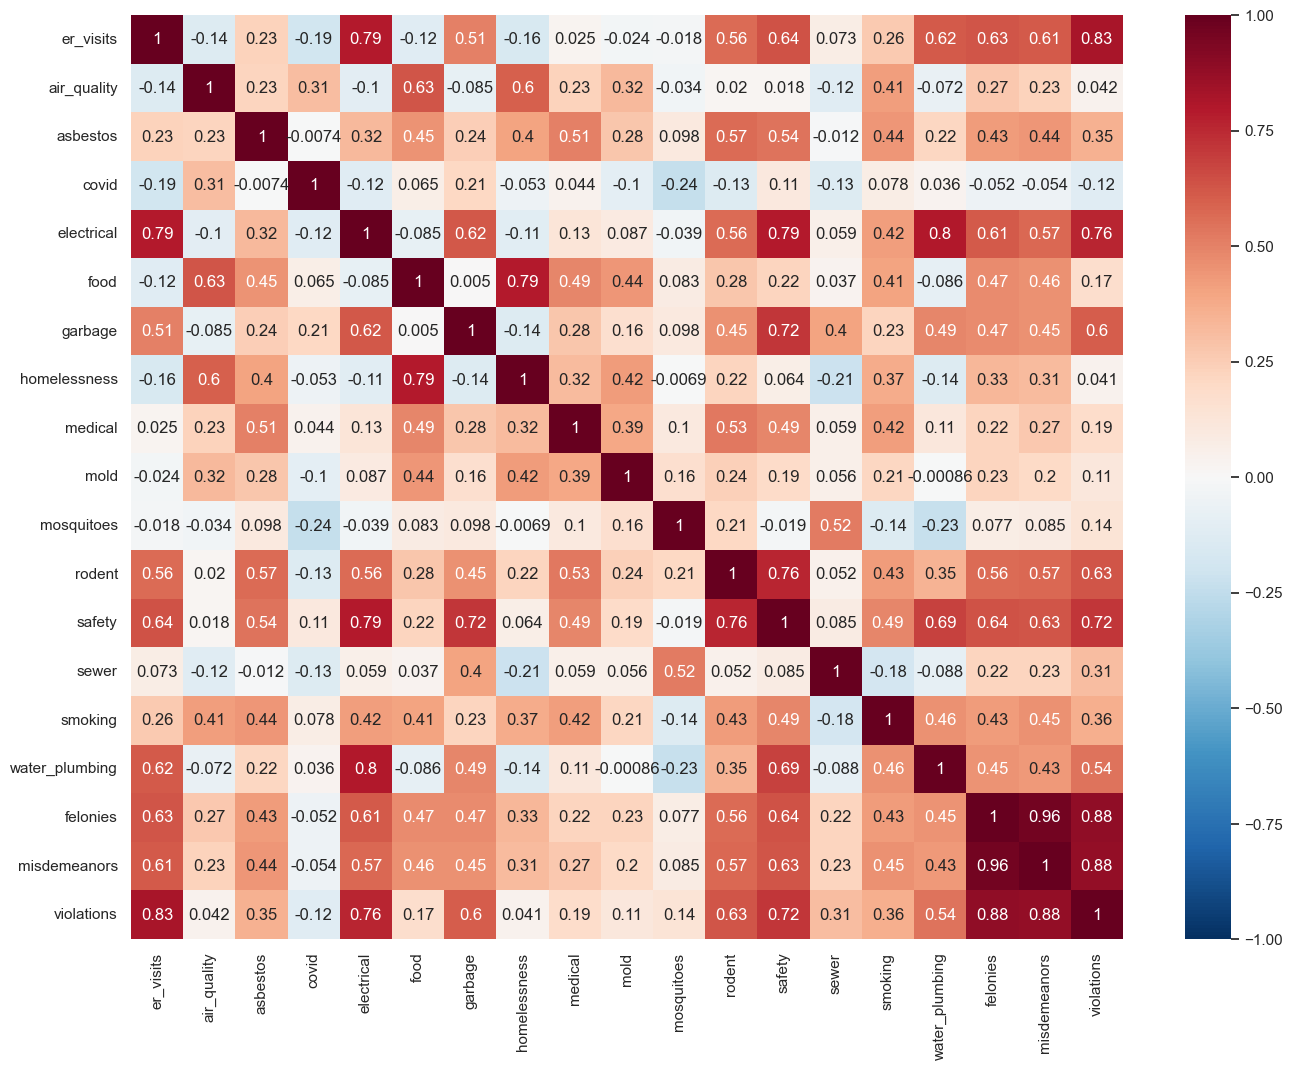

In [7]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
corr = df.corr(method='pearson')
sns.set(font_scale=1)
plt.figure(figsize=(16,12))
sns_plot = sns.heatmap(
    corr,        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1);

results_path = 'graphs/pearson-results.png'
    #print(results_path)
plt.savefig(results_path, dpi=400)

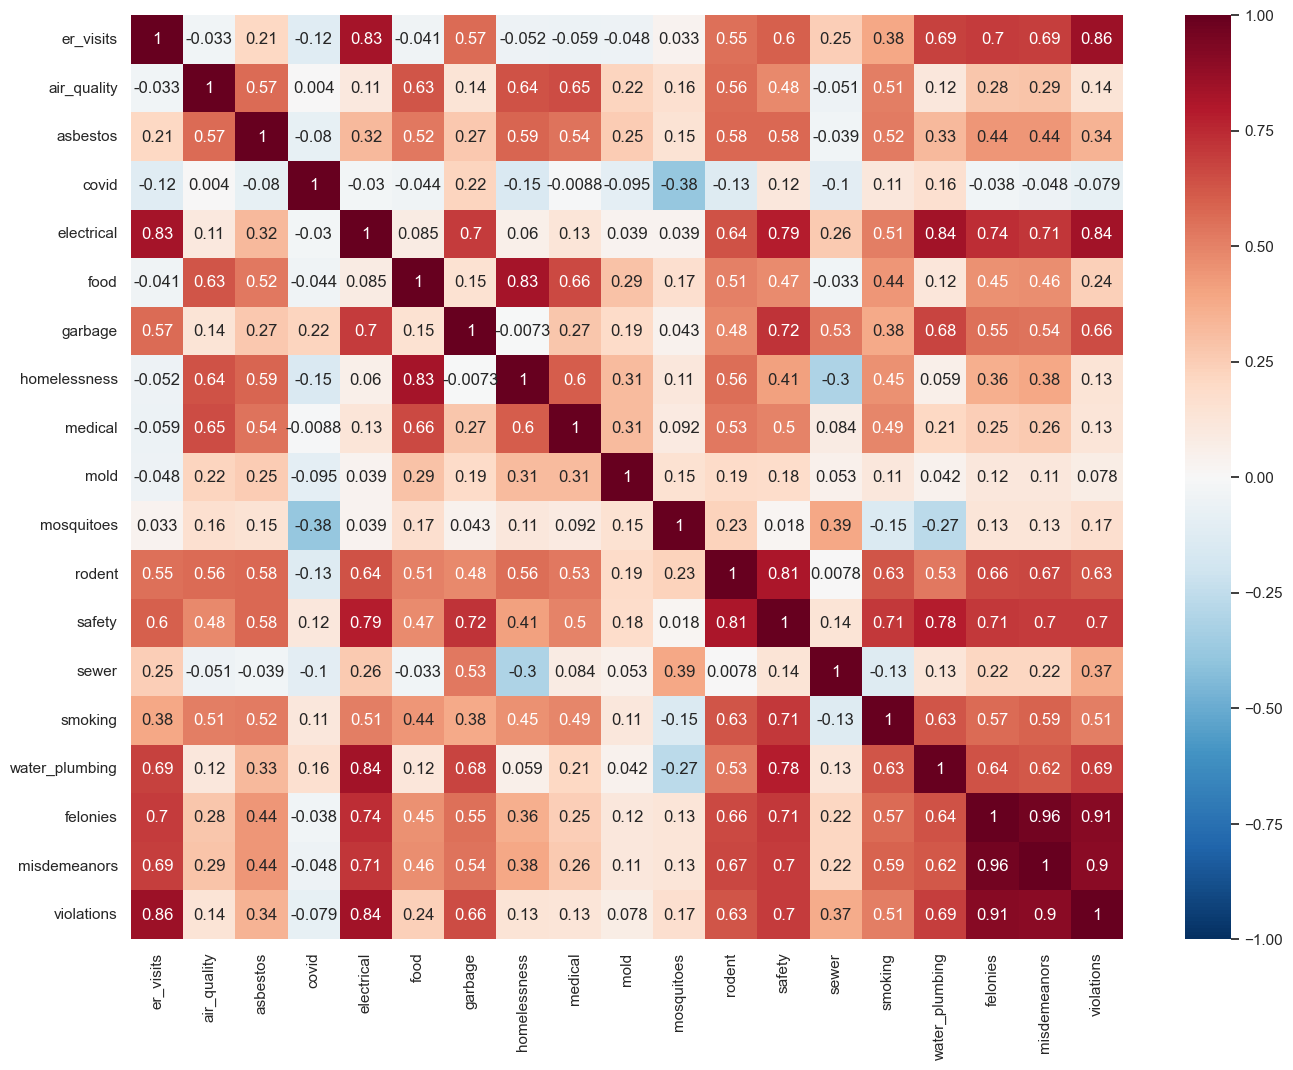

In [8]:
corr = df.corr(method='spearman')
sns.set(font_scale=1)
plt.figure(figsize=(16,12))
sns_plot = sns.heatmap(
    corr,        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1);

results_path = 'graphs/spearman-results.png'
    #print(results_path)
plt.savefig(results_path, dpi=400)

In [9]:
columns = df.columns[1:]
columns
len(columns)

18

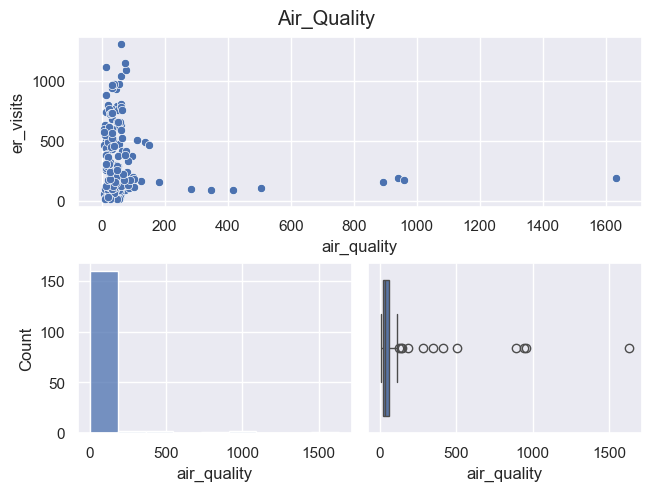

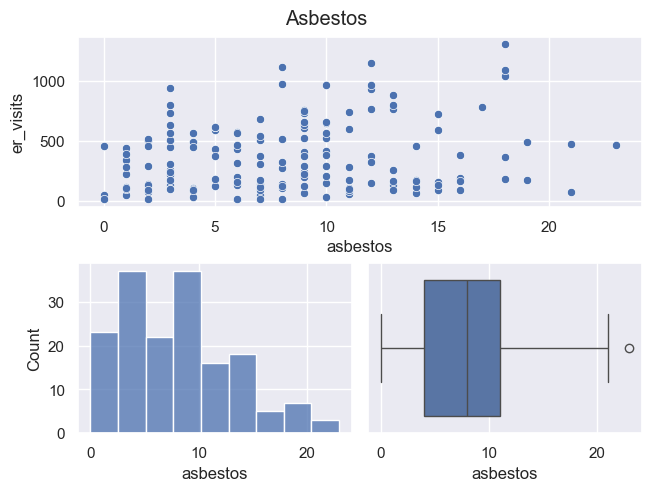

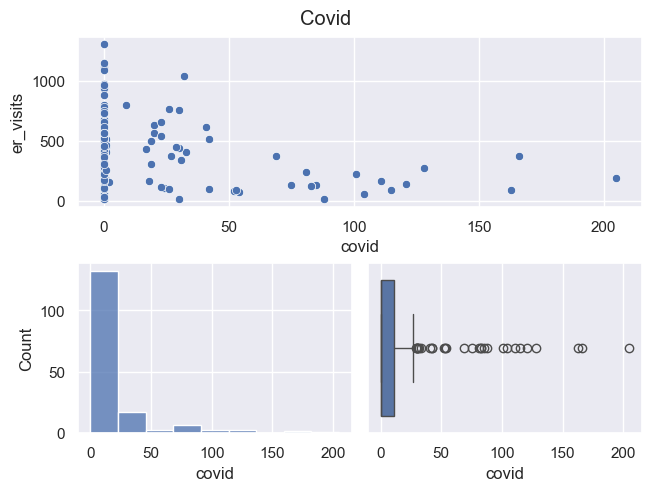

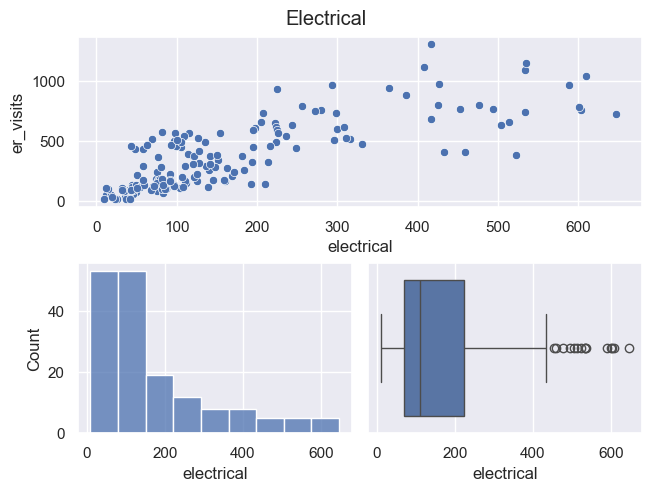

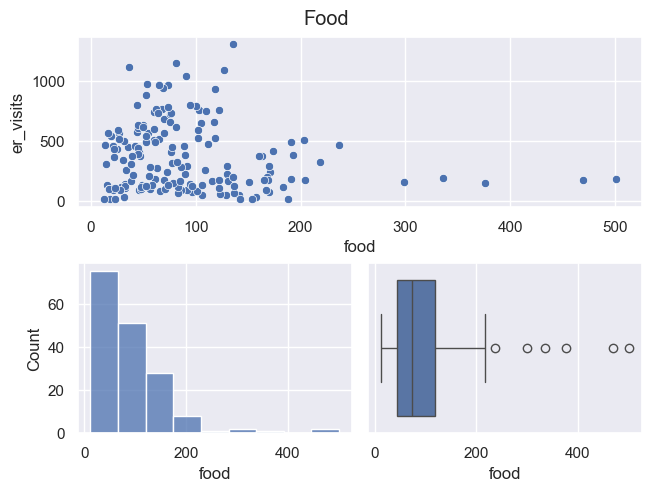

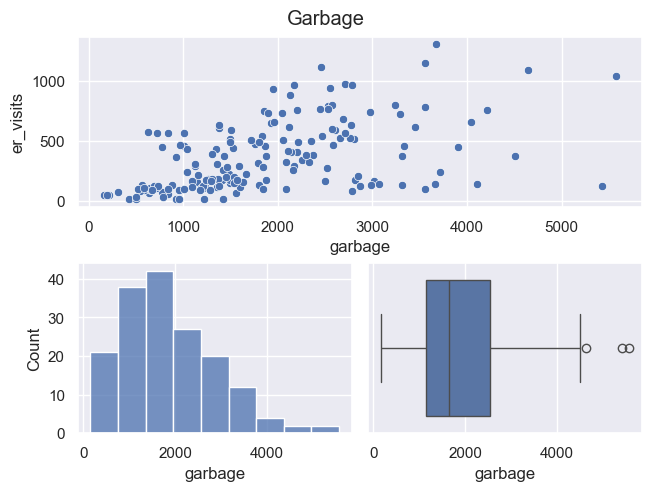

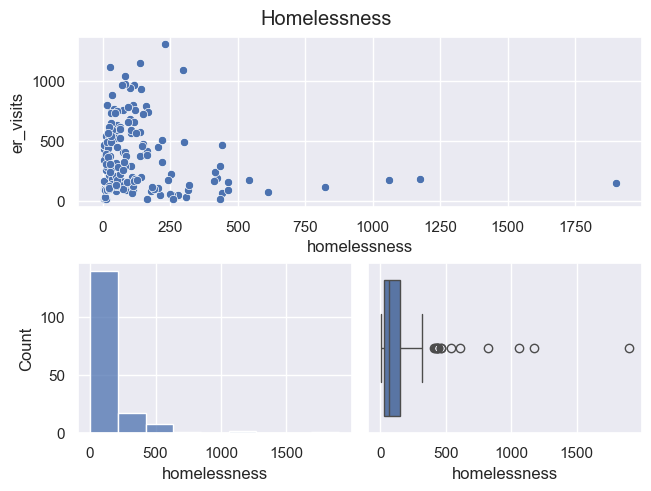

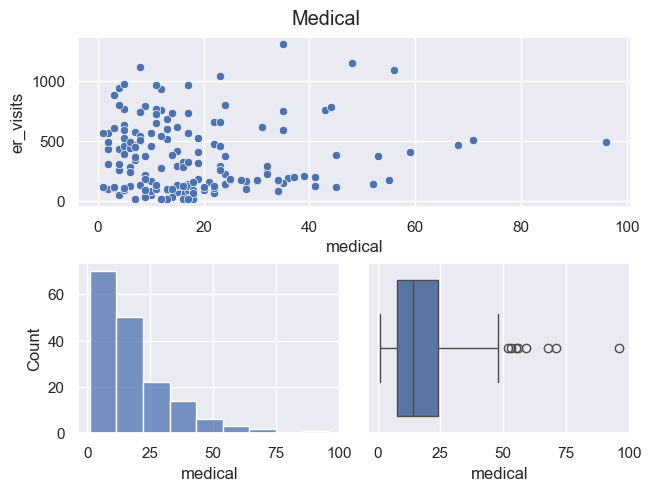

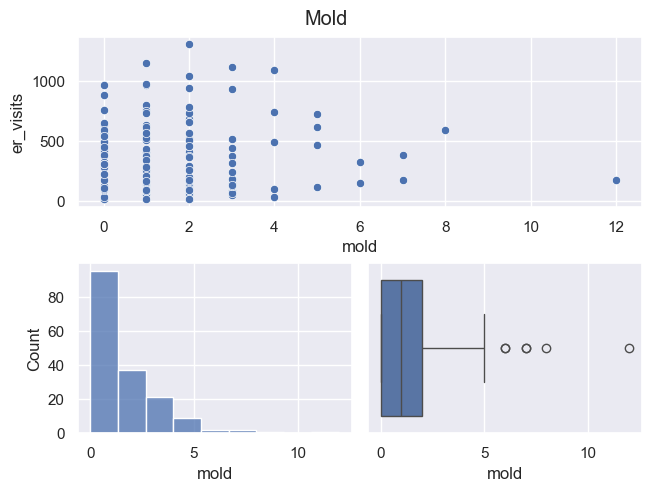

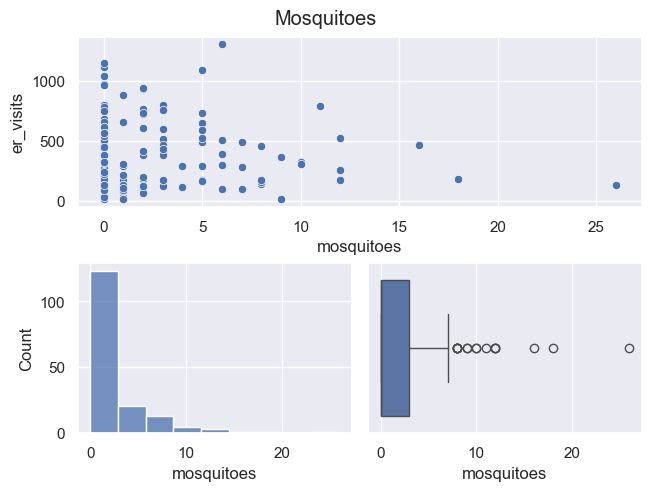

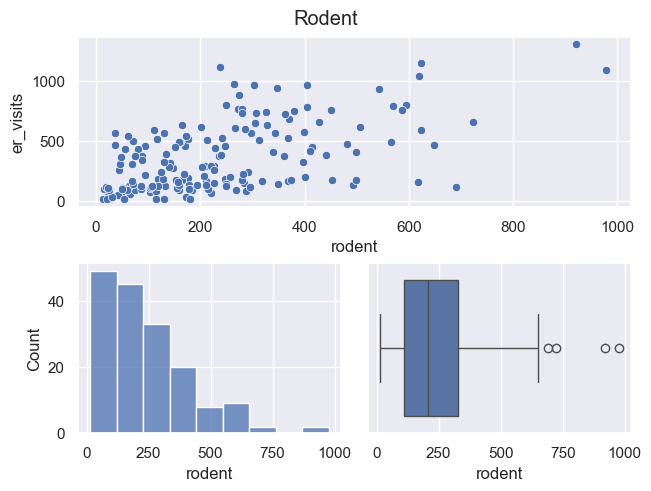

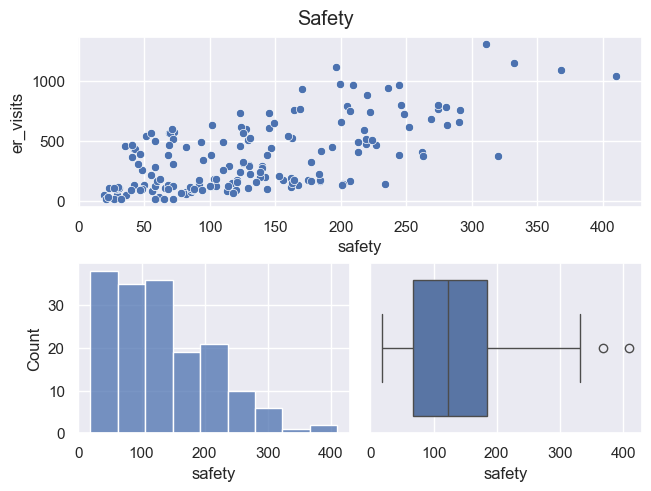

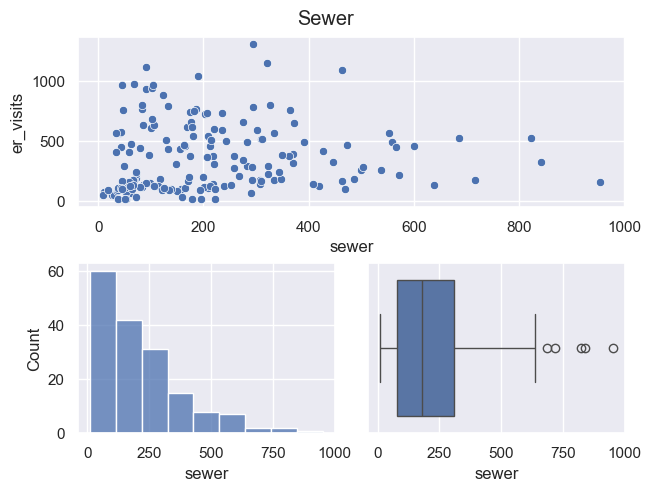

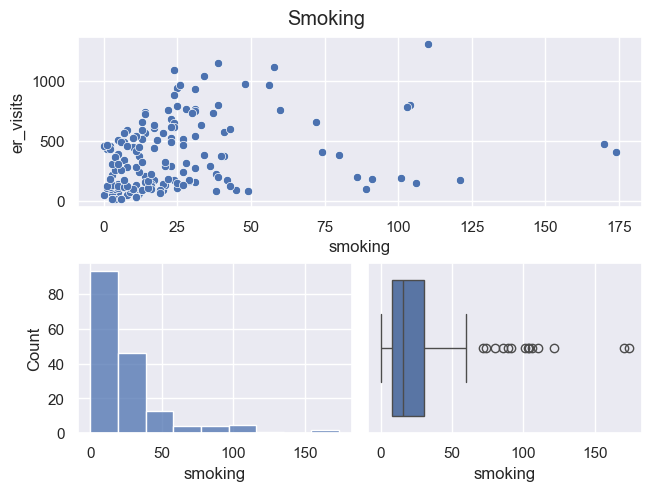

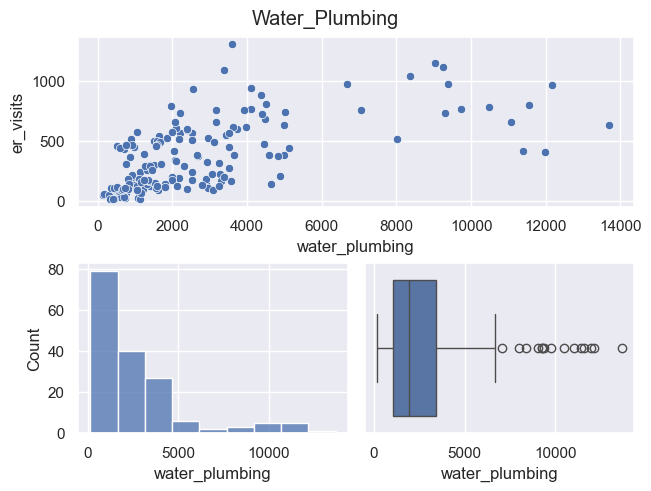

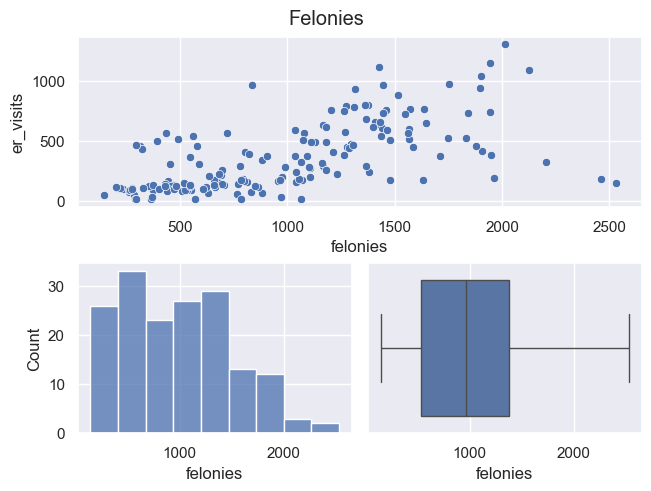

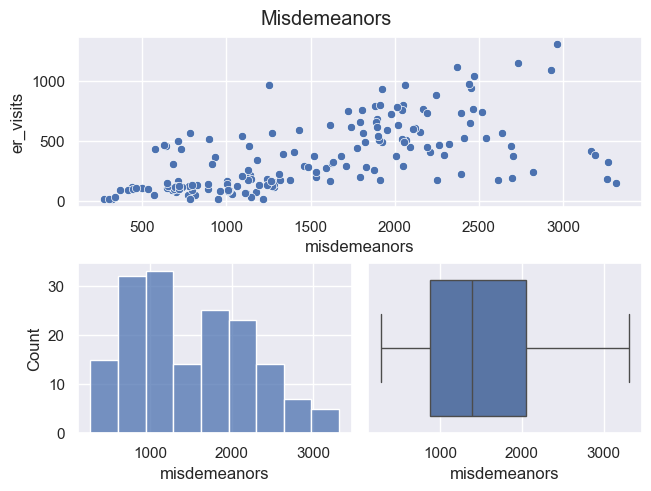

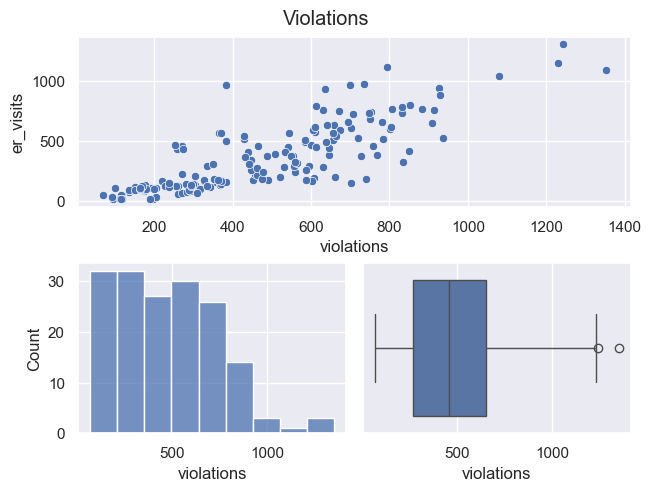

In [10]:

for idx in range(len(columns)):
    x_value = columns[idx]
    t_value = columns[idx].title()
    fig = plt.figure(constrained_layout=True)
    gs = GridSpec(2, 2, figure=fig)
    # create sub plots as grid
    ax1 = fig.add_subplot(gs[0, :])
    sns.scatterplot(data=df,x=x_value, y='er_visits')
    ax2 = fig.add_subplot(gs[1, 0])
    sns.histplot(x=x_value,data=df,bins=9)
    ax3 = fig.add_subplot(gs[1, 1])
    sns.boxplot(data=df,x=x_value,orient='h')
 
    # depict illustration
    fig.suptitle(t_value)
    fig.savefig('graphs/' + x_value + '.png', format='png')
    print('\n')

In [11]:
df.drop(columns=['air_quality','covid','mold','mosquitoes','felonies','misdemeanors'], axis=1, inplace=True)

In [12]:
abs_corr = df.corr()['er_visits'].apply(lambda x: abs(x))
abs_corr.sort_values(ascending=False, inplace=True)
abs_corr.drop(index='er_visits', axis=1, inplace=True)

In [13]:
abs_corr

violations        0.826234
electrical        0.793777
safety            0.639167
water_plumbing    0.616795
rodent            0.563376
garbage           0.507184
smoking           0.262010
asbestos          0.230972
homelessness      0.162723
food              0.124846
sewer             0.073048
medical           0.025137
Name: er_visits, dtype: float64

In [14]:
def do_regression(X_train, X_test, y_train, y_test, current_model):
    # Fit a least squares regression model
    current_model.fit(X_train, y_train)
    yPredicted = current_model.predict(X_train)
    print('coefficients: ', current_model.coef_)
    training_r = current_model.score(X_train,y_train)
    training_adj_r2 = 1 - ((1 - training_r) * (X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1) )
    testing_r = current_model.score(X_test, y_test)
    testing_adj_r2 = 1 - ((1 - testing_r) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1) )
    print('Training r_squared value: ',training_r)
    print('Training adjusted r_squared value: ', training_adj_r2)
    print('')
    print('Testing r_squared value: ', testing_r)
    print('Testing adjusted r_squared value: ', testing_adj_r2)
    print('')
    # Compute the sum of squared errors for the least squares model
    SSEreg = sum((y_train - yPredicted) ** 2)   #[0]
    print('SSE of Regression: ', SSEreg)
    # Compute the sum of squared errors for the horizontal line model
    SSEyBar = sum((y_train - np.mean(y_train)) ** 2)  #[0]
    print('SSE of mean: ', SSEyBar)
    dfn = 1.0                            # the y-intercept
    dfd = y_train.shape[0] - len(columns) + 1
    F_stat = ((SSEyBar - SSEreg) / (dfn) / (SSEreg / dfd ))
    print('F statistic: ', F_stat)
    p_value = 1 -f.cdf(F_stat, dfn, dfd)
    print('p-value: ', p_value, '\n')
    return training_adj_r2, testing_adj_r2


In [15]:
## Linear Regression
y = df[['er_visits']].values.reshape(-1,1)
columns = []
training = []
testing = []
SL = 0.05   # Significance Level
for i in range(len(abs_corr)):
    columns.append(abs_corr.index[i])
    print(columns)
    features = df[columns]
    X = features.values.reshape(-1, len(columns))
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=.3, random_state=24)
    linModel = linear_model.LinearRegression()
    training_r, testing_r = do_regression(X_train, X_test, y_train, y_test, linModel)
    training.append(training_r)
    testing.append(testing_r)

['violations']
coefficients:  [0.89601825]
Training r_squared value:  0.7314673787197228
Training adjusted r_squared value:  0.7291323124477204

Testing r_squared value:  0.6017756406407871
Testing adjusted r_squared value:  0.5936486128987624

SSE of Regression:  2233116.649695518
SSE of mean:  8315997.658119658
F statistic:  318.7012546266507
p-value:  1.1102230246251565e-16 

['violations', 'electrical']
coefficients:  [0.64037539 0.55525976]
Training r_squared value:  0.7749141108719362
Training adjusted r_squared value:  0.7709652356240755

Testing r_squared value:  0.6918765834639662
Testing adjusted r_squared value:  0.6790381077749648

SSE of Regression:  1871813.7268647603
SSE of mean:  8315997.658119658
F statistic:  399.35882790947034
p-value:  1.1102230246251565e-16 

['violations', 'electrical', 'safety']
coefficients:  [ 0.69143744  0.74022653 -0.61555853]
Training r_squared value:  0.7875353357719065
Training adjusted r_squared value:  0.7818946809693907

Testing r_squar

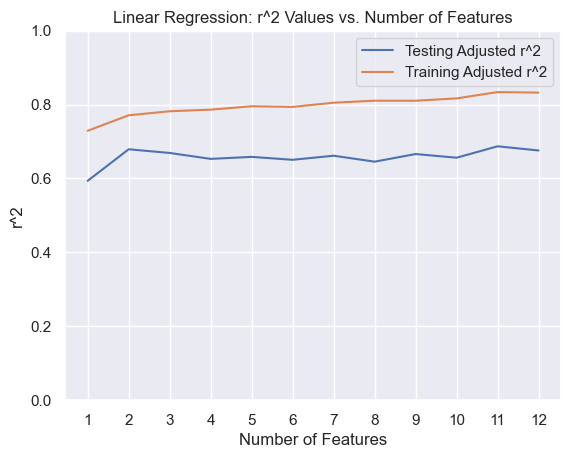

In [16]:
x_values = list(range(1,len(testing)+1))
plt.plot(x_values,testing, label="Testing Adjusted r^2")
plt.plot(x_values,training, label = "Training Adjusted r^2")
plt.title('Linear Regression: r^2 Values vs. Number of Features')
plt.legend()
plt.xticks(np.arange(min(x_values), max(x_values)+1, 1.0))
plt.xlabel('Number of Features')
plt.ylabel('r^2')
plt.gca().set_ylim([0.0, 1.0])
plt.show()

In [17]:
## Lasso Regression
columns = []
training = []
testing = []
SL = 0.05   # Significance Level
for i in range(4):
    columns.append(abs_corr.index[i])
    print(columns)
    features = df[columns]
    X = features.values.reshape(-1, len(columns))
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=.3, random_state=24)
    lassoModel = linear_model.Lasso(alpha=1.0)
    training_r, testing_r = do_regression(X_train, X_test, y_train, y_test, lassoModel)
    training.append(training_r)
    testing.append(testing_r)

['violations']
coefficients:  [0.89600281]
Training r_squared value:  0.7314673785024618
Training adjusted r_squared value:  0.7291323122285702

Testing r_squared value:  0.6017752990265561
Testing adjusted r_squared value:  0.5936482643128124

SSE of Regression:  2233116.6515022605
SSE of mean:  8315997.658119658
F statistic:  318.7012542741389
p-value:  1.1102230246251565e-16 

['violations', 'electrical']
coefficients:  [0.64045364 0.55511939]
Training r_squared value:  0.7749141079261408
Training adjusted r_squared value:  0.7709652326265994

Testing r_squared value:  0.6918614633365703
Testing adjusted r_squared value:  0.6790223576422607

SSE of Regression:  1871813.7513619866
SSE of mean:  8315997.658119658
F statistic:  399.35882116474914
p-value:  1.1102230246251565e-16 

['violations', 'electrical', 'safety']
coefficients:  [ 0.6913983   0.73999464 -0.61497052]
Training r_squared value:  0.7875353235993706
Training adjusted r_squared value:  0.7818946684736903

Testing r_squa

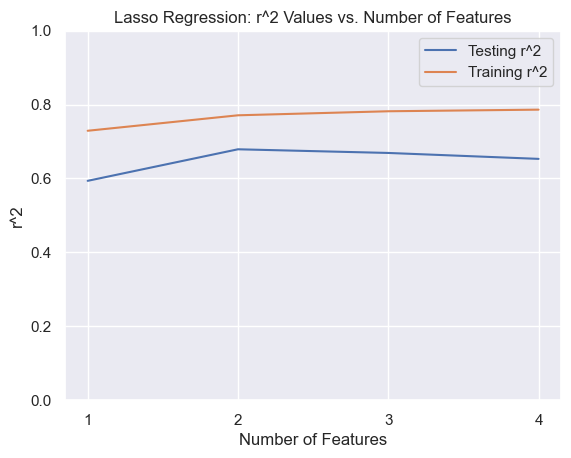

In [18]:
x_values = list(range(1,len(testing)+1))
plt.plot(x_values,testing, label="Testing r^2")
plt.plot(x_values,training, label = "Training r^2")
plt.title('Lasso Regression: r^2 Values vs. Number of Features')
plt.legend()
plt.xticks(np.arange(min(x_values), max(x_values)+1, 1.0))
plt.xlabel('Number of Features')
plt.ylabel('r^2')
plt.gca().set_ylim([0.0, 1.0])
plt.show()

In [19]:
## Ridge Regression
columns = []
training = []
testing = []
SL = 0.05   # Significance Level
for i in range(len(abs_corr)):
    columns.append(abs_corr.index[i])
    print(columns)
    features = df[columns]
    X = features.values.reshape(-1, len(columns))
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=.3, random_state=24)
    ridgeModel = linear_model.Ridge(alpha=10.0)
    training_r, testing_r = do_regression(X_train, X_test, y_train, y_test, ridgeModel)
    training.append(training_r)
    testing.append(testing_r)

['violations']
coefficients:  [0.89601707]
Training r_squared value:  0.7314673787184487
Training adjusted r_squared value:  0.7291323124464353

Testing r_squared value:  0.6017756144912867
Testing adjusted r_squared value:  0.5936485862155987

SSE of Regression:  2233116.6497061155
SSE of mean:  8315997.658119658
F statistic:  318.70125462458304
p-value:  1.1102230246251565e-16 

['violations', 'electrical']
coefficients:  [0.64037557 0.55525754]
Training r_squared value:  0.7749141108705893
Training adjusted r_squared value:  0.7709652356227048

Testing r_squared value:  0.6918762707798054
Testing adjusted r_squared value:  0.6790377820622973

SSE of Regression:  1871813.72687596
SSE of mean:  8315997.658119658
F statistic:  399.3588279063868
p-value:  1.1102230246251565e-16 

['violations', 'electrical', 'safety']
coefficients:  [ 0.6914355   0.74021322 -0.61552621]
Training r_squared value:  0.7875353357345236
Training adjusted r_squared value:  0.7818946809310154

Testing r_square

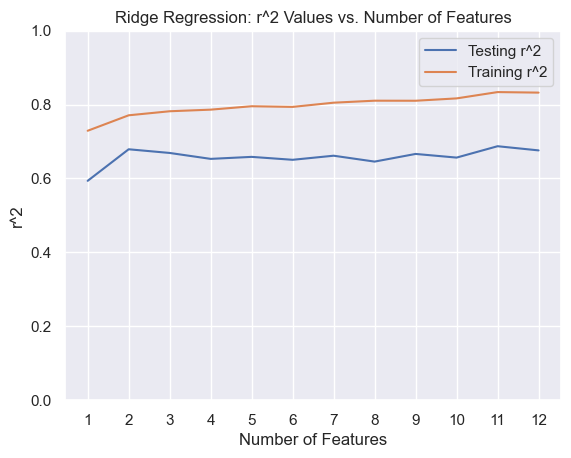

In [20]:
x_values = list(range(1,len(testing)+1))
plt.plot(x_values,testing, label="Testing r^2")
plt.plot(x_values,training, label = "Training r^2")
plt.title('Ridge Regression: r^2 Values vs. Number of Features')
plt.legend()
plt.xlabel('Number of Features')
plt.xticks(np.arange(min(x_values), max(x_values)+1, 1.0))
plt.gca().set_ylim([0.0, 1.0])
plt.ylabel('r^2')
plt.show()

In [21]:
## ElasticNet Regression - all
columns = []
training = []
testing = []
SL = 0.05   # Significance Level
for i in range(len(abs_corr)):
    columns.append(abs_corr.index[i])
    print(columns)
    features = df[columns]
    X = features.values.reshape(-1, len(columns))
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=.3, random_state=24)
    elasticModel = linear_model.ElasticNet(alpha=10.0)
    training_r, testing_r = do_regression(X_train, X_test, y_train, y_test, elasticModel)
    training.append(training_r)
    testing.append(testing_r)

['violations']
coefficients:  [0.89587187]
Training r_squared value:  0.7314673591970298
Training adjusted r_squared value:  0.7291322927552648

Testing r_squared value:  0.601772388462209
Testing adjusted r_squared value:  0.5936452943491929

SSE of Regression:  2233116.8120461884
SSE of mean:  8315997.658119658
F statistic:  318.7012229505689
p-value:  1.1102230246251565e-16 

['violations', 'electrical']
coefficients:  [0.64050105 0.55477455]
Training r_squared value:  0.774914068992091
Training adjusted r_squared value:  0.7709651930094962

Testing r_squared value:  0.6918142916452246
Testing adjusted r_squared value:  0.6789732204637755

SSE of Regression:  1871814.0751374536
SSE of mean:  8315997.658119658
F statistic:  399.3587320209901
p-value:  1.1102230246251565e-16 

['violations', 'electrical', 'safety']
coefficients:  [ 0.69112686  0.73830187 -0.61074791]
Training r_squared value:  0.7875345166773415
Training adjusted r_squared value:  0.7818938401289524

Testing r_squared

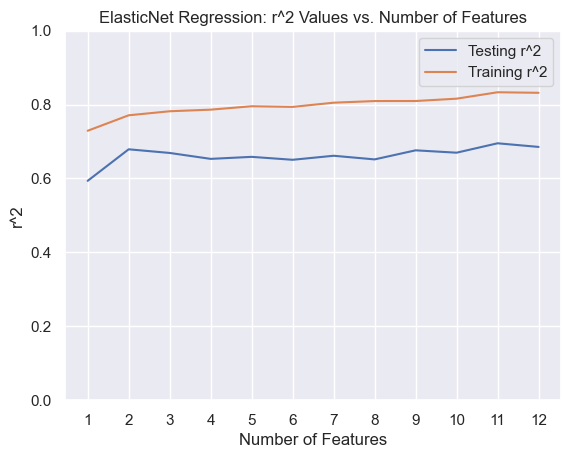

In [22]:
x_values = list(range(1,len(testing)+1))
plt.plot(x_values,testing, label="Testing r^2")
plt.plot(x_values,training, label = "Training r^2")
plt.title('ElasticNet Regression: r^2 Values vs. Number of Features')
plt.legend()
plt.xlabel('Number of Features')
plt.xticks(np.arange(min(x_values), max(x_values)+1, 1.0))
plt.ylabel('r^2')
plt.gca().set_ylim([0.0, 1.0])
plt.show()